In [1]:
#1. Data preprocessing
# hurricane segmentation data: 
# explaination of dataset: https://library.ucsd.edu/dc/object/bb94252168
# Download dataset: https://library.ucsd.edu/dc/object/bb94252168
import numpy as np
x = np.load("./data/hurricane_image.npy")
y = np.load("./data/hurricane_label.npy")

In [2]:
print(np.shape(x), np.shape(y))

(142, 24, 10, 128, 257, 6) (142, 24, 10, 128, 257, 1)


In [3]:
x = np.reshape(x , [142*24, 10, 128, 257, 6])
y = np.reshape(y, [142*24, 10, 128, 257, 1])

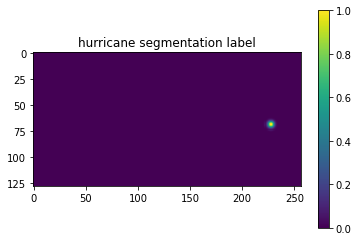

In [4]:
# description of output y
# heat map of hurricane (between 0 and 1)
import matplotlib.pyplot as plt

plt.imshow(y[70,0,:,:,0], interpolation='none')
plt.title('hurricane segmentation label')
plt.colorbar(orientation='vertical')
plt.show()

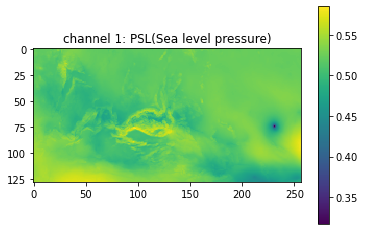

In [5]:
# description of input x
#Axis; Description; Size
#0; Number of hurricane videos
#1; Time; 10 (=30 hours)
#2; Width; 128 (= 64 degree = 6400 km)
#3; Height; 257(= 128.5 degree = 12850 km)
#4; Climate variables; 6 (by order: ['PSL','U850','V850','PRECT','TS','QREFHT'] )
plt.imshow(x[70,8,:,:,0], interpolation='none')
plt.colorbar(orientation='vertical')
plt.title('channel 1: PSL(Sea level pressure)')
plt.show()

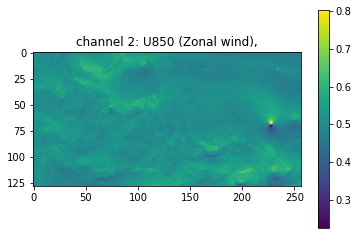

In [6]:
plt.imshow(x[70,0,:,:,1], interpolation='none')
plt.title('channel 2: U850 (Zonal wind),') #wind with x-axis (i.e. longitude)
plt.colorbar(orientation='vertical')
plt.show()

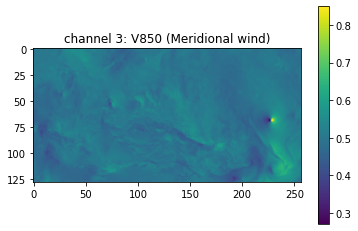

In [7]:
plt.imshow(x[70,0,:,:,2], interpolation='none')
plt.title('channel 3: V850 (Meridional wind)') #wind with  y- axis (i.e. latitude)
plt.colorbar(orientation='vertical')
plt.show()

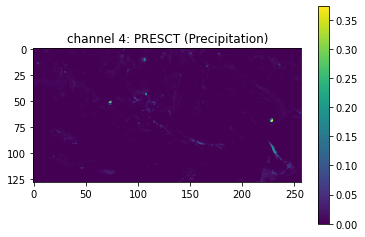

In [8]:
plt.imshow(x[70,0,:,:,3], interpolation='none')
plt.title('channel 4: PRESCT (Precipitation)')
plt.colorbar(orientation='vertical')
plt.show()

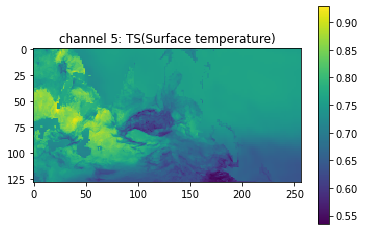

In [9]:
plt.imshow(x[70,0,:,:,4], interpolation='none')
plt.title('channel 5: TS(Surface temperature)')
plt.colorbar(orientation='vertical')
plt.show()

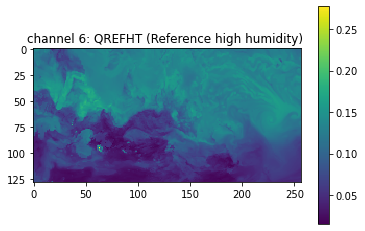

In [10]:
plt.imshow(x[70,0,:,:,5], interpolation='none')
plt.title('channel 6: QREFHT (Reference high humidity) ')
plt.colorbar(orientation='vertical')
plt.show()

In [11]:
# lets pick most relevant 3 channels
x = x[:,:,:,:,0:3]
print(np.shape(x), np.shape(y))

(3408, 10, 128, 257, 3) (3408, 10, 128, 257, 1)


In [12]:
# We don't have much dataset. so let's use 99% as training and 1% as test
train_x, test_x = x[int(142*24*0.01):142*24], x[0:int(142*24*0.01)]
train_y, test_y = y[int(142*24*0.01):142*24], y[0:int(142*24*0.01)]
print(np.shape(train_x), np.shape(train_y), np.shape(test_x), np.shape(test_y))

(3374, 10, 128, 257, 3) (3374, 10, 128, 257, 1) (34, 10, 128, 257, 3) (34, 10, 128, 257, 1)


In [13]:
# Model: ConvLSTM/ConvGRU
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import layers
convlstm = Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    layers.ConvLSTM2D(filters=8, kernel_size=(3,3), input_shape=(10,128,257,3), padding="same", return_sequences=True),
    layers.ConvLSTM2D(16, (5,5),  padding="same", return_sequences=True),
    layers.ConvLSTM2D(1, (9,9),  padding="same", return_sequences=True)
  ])

2021-09-20 20:52:28.769935: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-20 20:52:28.771158: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 16. Tune using inter_op_parallelism_threads for best performance.


In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
convlstm.compile(loss='mse', optimizer=optimizer, metrics=['mse'])
convlstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 10, 128, 257, 8)   3200      
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 10, 128, 257, 16)  38464     
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 10, 128, 257, 1)   5512      
Total params: 47,176
Trainable params: 47,176
Non-trainable params: 0
_________________________________________________________________


In [15]:
#let's do whether model works okay
example_batch = train_x[0:2]
example_result = convlstm.predict(example_batch)

In [16]:
print(np.shape(train_x[0:2]), np.shape(example_result))

(2, 10, 128, 257, 3) (2, 10, 128, 257, 1)


In [17]:
#Let's do training with model.fit
EPOCHS = 200
history = convlstm.fit(
  train_x, train_y,
  epochs=EPOCHS, validation_split = 0.1, verbose=1)

Train on 3036 samples, validate on 338 samples
Epoch 1/200
 352/3036 [==>...........................] - ETA: 2:15:17 - loss: 0.0073 - mse: 0.0073

KeyboardInterrupt: 

In [ ]:
import pandas as pd
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,0.2])
  plt.legend()
  plt.show()

plot_history(history)

In [ ]:
test_predictions = model.predict(test_x)
print(np.shape(test_y), np.shape(test_predictions))

In [ ]:
#Evaluate with test set
loss,  mse = model.evaluate(test_x, test_y, verbose=2)
print("MSE of testset: {:5.2f}".format(mse))

In [ ]:
plt.imshow(train_y[10,0,:,:,0], interpolation='none')
plt.title('GT')
plt.colorbar(orientation='vertical')
plt.show()

In [ ]:
plt.imshow(test_predictions[10,0,:,:,0], interpolation='none')
plt.title('Prediction')
plt.colorbar(orientation='vertical')
plt.show()